In [2]:
!pip install disarray

In [3]:
import tensorflow
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import shutil
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sklearn

In [4]:
def count_jpg_files(root_dir):
    """
    Count all .jpg files in the given directory and its subdirectories
    
    Args:
        root_dir (str): Path to the root directory to start searching from
        
    Returns:
        int: total count
    """
    total_count = 0
    dir_counts = {}
    
    # Walk through all directories
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Count jpg files in current directory
        jpg_count = len([f for f in filenames if f.lower().endswith('.jpg')])
        total_count += jpg_count
    
    return total_count

In [5]:
train_path = '/kaggle/input/multiclasscovidoasegmentedimages/covidoa_segmented_images/train_directory'
validation_path = '/kaggle/input/multiclasscovidoasegmentedimages/covidoa_segmented_images/validation_directory'
test_path = '/kaggle/input/multiclasscovidoasegmentedimages/covidoa_segmented_images/test_directory'

In [6]:
preprocess_input = tensorflow.keras.applications.densenet.preprocess_input

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
batch_size = 64
train_image_gen = image_gen.flow_from_directory(train_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical')

val_image_gen = image_gen.flow_from_directory(validation_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

test_image_gen = image_gen.flow_from_directory(test_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

print(test_image_gen.class_indices)

Found 36927 images belonging to 7 classes.
Found 883 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [8]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + K.epsilon())
    return precision_value

def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + K.epsilon())
    return recall_value

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1_score_value = 2*((precision_value*recall_value)/(precision_value+recall_value+K.epsilon()))
    return f1_score_value

In [10]:
tl_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 13,461,063 (51.35 MB)

 Trainable params: 13,377,415 (51.03 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [11]:
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy, precision, recall, f1_score])

In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(
    monitor='val_categorical_accuracy',
    factor=0.1,
    patience=2,        
    mode='max',
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,       
    mode='min',
    restore_best_weights=True,
    verbose=1
)

model_chkpt = ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    verbose=1
)

callback_list = [model_chkpt, lr_reduce, early_stop]

In [13]:
total_samples = sum([5115, 5950, 5990, 5462, 5510, 4810, 4090])
class_weights = {
    0: total_samples / 5510,
    1: total_samples / 5462,
    2: total_samples / 5990,
    3: total_samples / 4090,
    4: total_samples / 5950,
    5: total_samples / 5115,
    6: total_samples / 4810
}

In [14]:
history = tl_model.fit(train_image_gen,
                       epochs=30, 
                       validation_data = val_image_gen,
                       class_weight = class_weights,
                       callbacks=callback_list)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - categorical_accuracy: 0.4280 - f1_score: 0.3495 - loss: 10.5435 - precision: 0.6757 - recall: 0.2477 - top_2_accuracy: 0.6275 - top_3_accuracy: 0.7558
Epoch 1: val_categorical_accuracy improved from -inf to 0.81087, saving model to best_model.keras
577/577 ━━━━━━━━━━━━━━━━━━━━ 518s 635ms/step - categorical_accuracy: 0.4282 - f1_score: 0.3497 - loss: 10.5400 - precision: 0.6758 - recall: 0.2479 - top_2_accuracy: 0.6277 - top_3_accuracy: 0.7559 - val_categorical_accuracy: 0.8109 - val_f1_score: 0.7697 - val_loss: 0.5426 - val_precision: 0.8797 - val_recall: 0.7058 - val_top_2_accuracy: 0.9185 - val_top_3_accuracy: 0.9660 - learning_rate: 1.0000e-04
Epoch 2/30
577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - categorical_accuracy: 0.6476 - f1_score: 0.6192 - loss: 6.1029 - precision: 0.7967 - recall: 0.5089 - top_2_accuracy: 0.8338 - top_3_accuracy: 0.9218
Epoch 2: val_categorical_accuracy improved from 0.81087 to 0.87429, saving model to best_model

In [15]:
tl_model.save('val_loss_epoch.keras')

<Axes: >

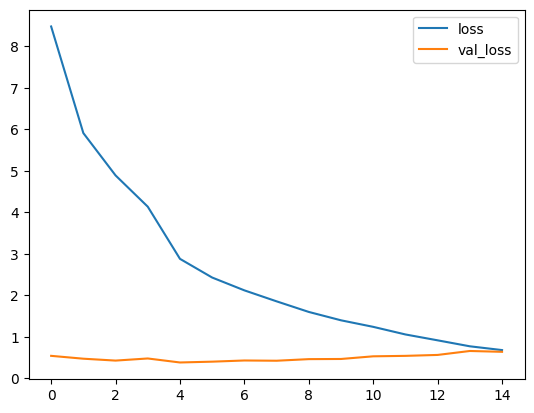

In [16]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

<Axes: >

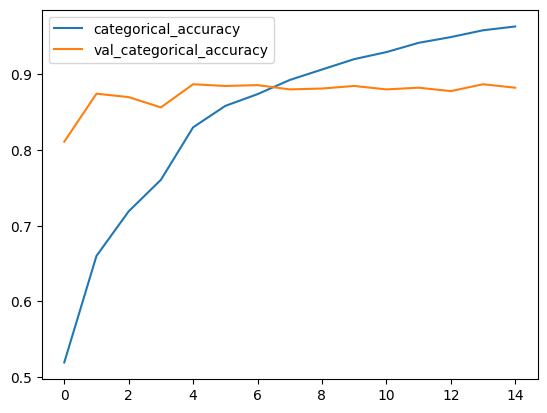

In [17]:
metrics[["categorical_accuracy","val_categorical_accuracy"]].plot()

<Figure size 640x480 with 0 Axes>

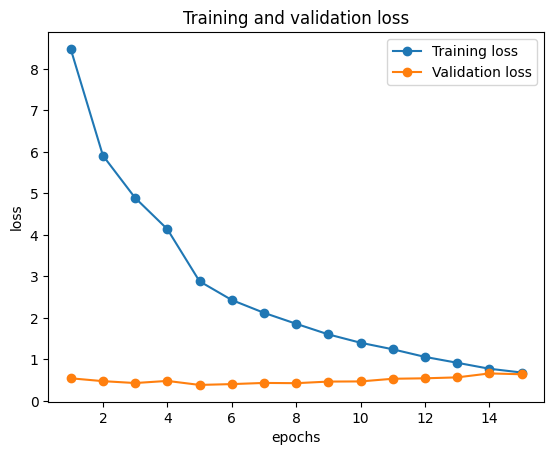

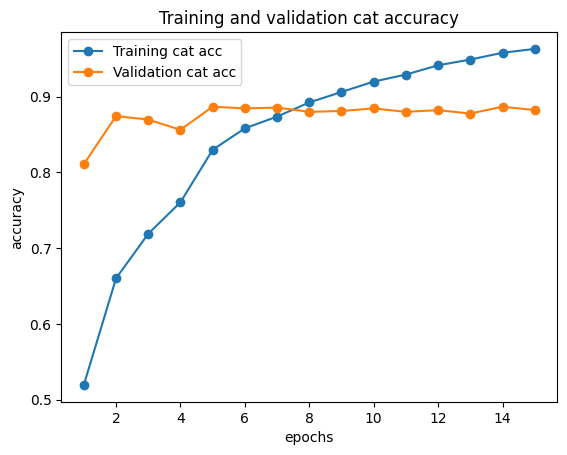

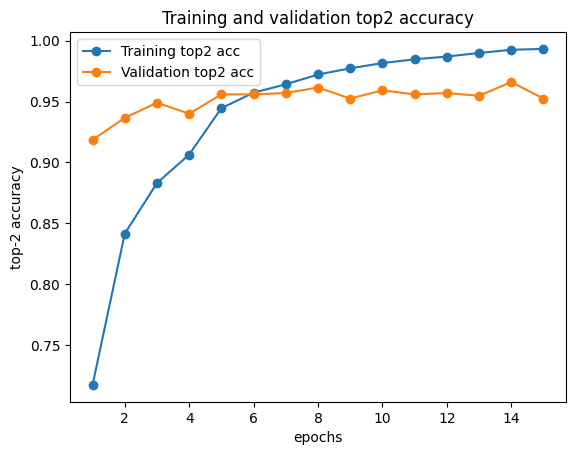

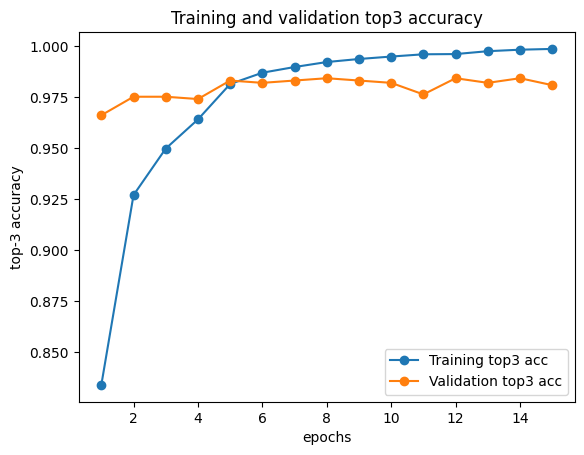

<Figure size 640x480 with 0 Axes>

In [18]:
# display the accuracy, top-2 accuracy and top-3 accuracy

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, "-o", label='Training loss')
plt.plot(epochs, val_loss, "-o", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
# plt.figure()
plt.savefig('loss.png', dpi=300)
plt.figure()

plt.plot(epochs, acc, "-o", label='Training cat acc')
plt.plot(epochs, val_acc, "-o", label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
# plt.figure()
plt.savefig('acc.png', dpi=300)
plt.figure()

plt.plot(epochs, train_top2_acc, "-o", label='Training top2 acc')
plt.plot(epochs, val_top2_acc, "-o", label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.xlabel('epochs')
plt.ylabel('top-2 accuracy')
plt.legend()
# plt.figure()
plt.savefig('top2acc.png', dpi=300)
plt.figure()

plt.plot(epochs, train_top3_acc, "-o", label='Training top3 acc')
plt.plot(epochs, val_top3_acc, "-o", label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.xlabel('epochs')
plt.ylabel('top-3 accuracy')
plt.legend()
# plt.figure()
plt.savefig('top3acc.png', dpi=300)
plt.figure()

In [19]:
tl_model.load_weights('best_model.keras')
VALIDATION_STEPS = int(np.ceil(count_jpg_files(validation_path) / 64))

In [20]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc, val_precision, val_recall, val_f1_score = tl_model.evaluate(val_image_gen, steps=VALIDATION_STEPS)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)
print('val_precision:', val_precision)
print('val_recall:', val_recall)
print('val_f1_score', val_f1_score)

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - categorical_accuracy: 0.7756 - f1_score: 0.7548 - loss: 0.7770 - precision: 0.7879 - recall: 0.7279 - top_2_accuracy: 0.9034 - top_3_accuracy: 0.9657
val_loss: 0.3827544152736664
val_cat_acc: 0.8867497444152832
val_top_2_acc: 0.9558323621749878
val_top_3_acc: 0.9830124378204346
val_precision: 0.8973625302314758
val_recall: 0.8627013564109802
val_f1_score 0.8787771463394165


In [21]:
TEST_STEPS = int(np.ceil(count_jpg_files(test_path) / 64))

In [22]:
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc, test_precision, test_recall, test_f1_score = tl_model.evaluate(test_image_gen, steps=TEST_STEPS)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)
print('test_precision:', test_precision)
print('test_recall:', test_recall)
print('test_f1_score', test_f1_score)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 816ms/step - categorical_accuracy: 0.7756 - f1_score: 0.7668 - loss: 0.7602 - precision: 0.7912 - recall: 0.7457 - top_2_accuracy: 0.8952 - top_3_accuracy: 0.9528
test_loss: 0.37536439299583435
test_cat_acc: 0.8884859681129456
test_top_2_acc: 0.9519492387771606
test_top_3_acc: 0.9791477918624878
test_precision: 0.8974895477294922
test_recall: 0.8756365776062012
test_f1_score 0.8859260082244873


In [23]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 596ms/step


In [24]:
test_labels = test_image_gen.classes

In [25]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(test_labels, predictions)

Normalized confusion matrix
[[0.4        0.16666667 0.2        0.         0.06666667 0.16666667
  0.        ]
 [0.14285714 0.74285714 0.02857143 0.         0.02857143 0.05714286
  0.        ]
 [0.01136364 0.05681818 0.52272727 0.02272727 0.13636364 0.25
  0.        ]
 [0.         0.125      0.         0.375      0.         0.5
  0.        ]
 [0.         0.04347826 0.13043478 0.         0.41304348 0.41304348
  0.        ]
 [0.0011325  0.00339751 0.01019253 0.00339751 0.00566251 0.97621744
  0.        ]
 [0.         0.         0.         0.         0.         0.07692308
  0.92307692]]


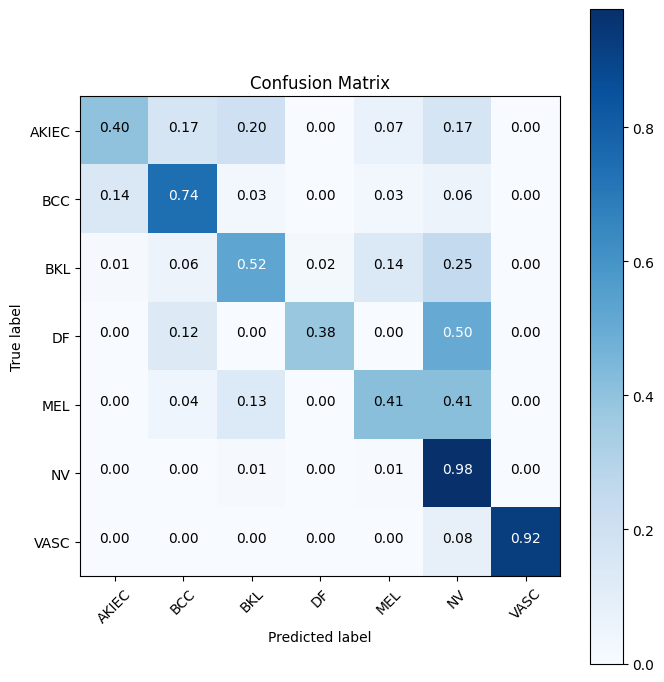

In [26]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusionmatrix.png', dpi=300)

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [27]:
import disarray

df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,micro-average
accuracy,0.977335,0.977335,0.941976,0.990934,0.957389,0.932910,0.999093,0.968139
f1,0.489796,0.675325,0.589744,0.375000,0.447059,0.958843,0.960000,0.888486
false_discovery_rate,0.368421,0.380952,0.323529,0.625000,0.512821,0.057923,0.000000,0.111514
false_negative_rate,0.600000,0.257143,0.477273,0.625000,0.586957,0.023783,0.076923,0.111514
false_positive_rate,0.006524,0.014981,0.021675,0.004566,0.018921,0.240909,0.000000,0.018586
negative_predictive_value,0.983395,0.991517,0.959420,0.995434,0.974624,0.888298,0.999083,0.981414
positive_predictive_value,0.631579,0.619048,0.676471,0.375000,0.487179,0.942077,1.000000,0.888486
precision,0.631579,0.619048,0.676471,0.375000,0.487179,0.942077,1.000000,0.888486
recall,0.400000,0.742857,0.522727,0.375000,0.413043,0.976217,0.923077,0.888486
sensitivity,0.400000,0.742857,0.522727,0.375000,0.413043,0.976217,0.923077,0.888486


In [39]:
tl_model.load_weights('val_loss_epoch.keras')
VALIDATION_STEPS = int(np.ceil(count_jpg_files(validation_path) / 64))

In [40]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc, val_precision, val_recall, val_f1_score = tl_model.evaluate(val_image_gen, steps=VALIDATION_STEPS)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)
print('val_precision:', val_precision)
print('val_recall:', val_recall)
print('val_f1_score', val_f1_score)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - categorical_accuracy: 0.7756 - f1_score: 0.7548 - loss: 0.7770 - precision: 0.7879 - recall: 0.7279 - top_2_accuracy: 0.9034 - top_3_accuracy: 0.9657
val_loss: 0.3827544152736664
val_cat_acc: 0.8867497444152832
val_top_2_acc: 0.9558323621749878
val_top_3_acc: 0.9830124378204346
val_precision: 0.8973625302314758
val_recall: 0.8627013564109802
val_f1_score 0.8787771463394165


In [41]:
TEST_STEPS = int(np.ceil(count_jpg_files(test_path) / 64))

In [42]:
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc, test_precision, test_recall, test_f1_score = tl_model.evaluate(test_image_gen, steps=TEST_STEPS)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)
print('test_precision:', test_precision)
print('test_recall:', test_recall)
print('test_f1_score', test_f1_score)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - categorical_accuracy: 0.7756 - f1_score: 0.7668 - loss: 0.7602 - precision: 0.7912 - recall: 0.7457 - top_2_accuracy: 0.8952 - top_3_accuracy: 0.9528
test_loss: 0.37536439299583435
test_cat_acc: 0.8884859681129456
test_top_2_acc: 0.9519492387771606
test_top_3_acc: 0.9791477918624878
test_precision: 0.8974895477294922
test_recall: 0.8756365776062012
test_f1_score 0.8859260082244873


In [43]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes
cm = confusion_matrix(test_labels, predictions)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step


Normalized confusion matrix
[[0.4        0.16666667 0.2        0.         0.06666667 0.16666667
  0.        ]
 [0.14285714 0.74285714 0.02857143 0.         0.02857143 0.05714286
  0.        ]
 [0.01136364 0.05681818 0.52272727 0.02272727 0.13636364 0.25
  0.        ]
 [0.         0.125      0.         0.375      0.         0.5
  0.        ]
 [0.         0.04347826 0.13043478 0.         0.41304348 0.41304348
  0.        ]
 [0.0011325  0.00339751 0.01019253 0.00339751 0.00566251 0.97621744
  0.        ]
 [0.         0.         0.         0.         0.         0.07692308
  0.92307692]]


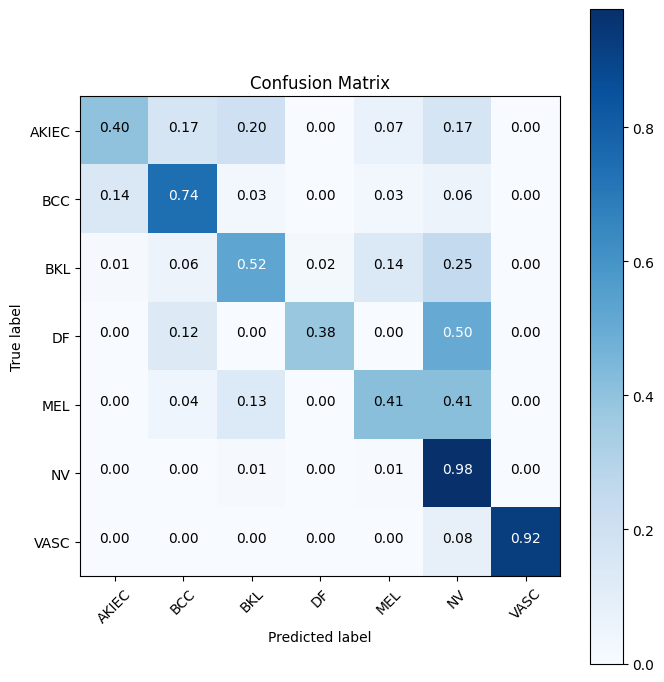

In [44]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusionmatrix.png', dpi=300)

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [45]:
import disarray

df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,micro-average
accuracy,0.977335,0.977335,0.941976,0.990934,0.957389,0.932910,0.999093,0.968139
f1,0.489796,0.675325,0.589744,0.375000,0.447059,0.958843,0.960000,0.888486
false_discovery_rate,0.368421,0.380952,0.323529,0.625000,0.512821,0.057923,0.000000,0.111514
false_negative_rate,0.600000,0.257143,0.477273,0.625000,0.586957,0.023783,0.076923,0.111514
false_positive_rate,0.006524,0.014981,0.021675,0.004566,0.018921,0.240909,0.000000,0.018586
negative_predictive_value,0.983395,0.991517,0.959420,0.995434,0.974624,0.888298,0.999083,0.981414
positive_predictive_value,0.631579,0.619048,0.676471,0.375000,0.487179,0.942077,1.000000,0.888486
precision,0.631579,0.619048,0.676471,0.375000,0.487179,0.942077,1.000000,0.888486
recall,0.400000,0.742857,0.522727,0.375000,0.413043,0.976217,0.923077,0.888486
sensitivity,0.400000,0.742857,0.522727,0.375000,0.413043,0.976217,0.923077,0.888486
